<a href="https://colab.research.google.com/github/ratkovic/FSU/blob/main/ProblemSet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Part 1: Building a Model and Globe-tossing

## Some of this part's material comes from

Statistical Rethinking

- <https://learning.oreilly.com/library/view/statistical-rethinking/9781482253481/>

Corresponding Code

- <https://bookdown.org/content/4857/>

"Between the devil and the deep blue sea: Tensions between scientific judgement and statistical model selection"  by Danielle J. Navarro

- <https://psyarxiv.com/39q8y/>

## Libraries we will need

Please note that if a library is not installed, you will need to do so! Note that this may take (quite) a few minutes the first time.

Also note that you can download



In [35]:
packages <- c('tidyverse', 'brms', 'dplyr','mixtools')
install.packages(setdiff(packages, rownames(installed.packages())))

library(tidyverse)
library(dplyr)
library(brms)



## Statistical Golems: The Model


Sometimes their unyielding logic reveals implications previously hidden to their designers. These implications can be priceless discoveries. Or they may produce silly and dangerous behavior. Rather than idealized angels of reason, scientific models are powerful clay robots without intent of their own, bumbling along according to the myopic instructions they embody. Like with Rabbi Judah’s golem, the golems of science are wisely regarded with both awe and apprehension. We absolutely have to use them, but doing so always entails some risk.

## Bayes, Models, Parameters, and Estimation

Bayesian Statistics relies on a fully specified model of the outcome. As we discuss in lecture, this means that Bayesians produce a full, transparent statistical model of the data and how the data will inform inference.  On first glance this may seem unobjetionable, but let's contrast it with standard, frequentist approaches in our field.   

Consider, for example, heteroskedasticity in your regression's residuals.  The frequentist might implement ``heteroskedasticity robust standard errors,'' which allow for valid inference on regression coefficients without specifying the heteroskedasticity.  Setting aside the inherent difference in inferential frameworks, the Bayesian would urge the social scientist to model the heteroskedasticity and try to learn something from it.  The frequentist would, instead, say that the heteroskedasticity is simply nuisance and distracting from the question at hand, the regression coefficients.

Similar arguments play out when using  ``Cluster Robust Standard Errors'', where Bayesian would turn to a hierarchical linear model.  Both views have value, but I am going to suggest that you rely on frequentist methods for simple questions, i.e. a regression coefficient or ATE/ATT, but use Bayesian methods when looking to model complex phenomena: hierarchical models, panel models, and, ultimately, networks, images, and text.

This chain of argument puts model selection at the core of Bayesian statistics, to which we turn next.

## Model Selection

Consider the posterior density for a given set of parameters $\theta$ given a model, $\mathcal M$ and data $\mathcal D$:

- $Pr(\theta| \mathcal D, \mathcal M)$

How should we choose choose among models?

- $Pr(\mathcal M|\mathcal D)$

i.e. compare $\mathcal M_1$ and $\mathcal M_2$, i.e. $Pr(\mathcal M_1|\mathcal D)$ vs $Pr(\mathcal M_2|\mathcal D)$?


## General Thoughts

This question will be aesthetic as well as mathematical.  There is always Occam's razor, but here's a few more quotes that guide me on assessing models:

Dennis Lindley:

- If you can’t do simple problems, how can you do complicated ones?

George Box:

- Since all models are wrong the scientist must be alert to what is importantly wrong. It is  inappropriate to be concerned about mice when there are tigers abroad.

Bernardo and Smith:

- Many authors . . . highlight a distinction between what one might call scientific and technological approaches to models. The essence of the dichotomy is that scientists are assumed to seek explanatory models, which aim at providing insight into and understanding of the “true” mechanisms of the phenomenon under study; whereas technologists are content with empirical models, which are not concerned with the “truth”, but simply providing a reliably basis for practical action in predicting and controlling phenomena of interest.
- See Breiman, ``Statistics: The Two Cultures"

We will return to criteria for selecting across models after practicing sampling from a posterior.

## Globe tossing: An Example of Bayesian Updating

We begin with a simple example, showing how the data, working through the likelihood, and the prior can combine to generate a posterior density.  Let's imagine we want to estimate the proportion of the earth's surface that is covered with water (correct answer: 2/3 and, yes, the earth is round).  We could do this by randomly selecting points on a globe and calculating the percent that are water.


## Building a Model

In a Bayesian setting, the components of a model are:

- A likelihood function: ``The number of ways each conjecture could produce an observation''

- The parameters: ``the accumulated number of ways each conjecture cold produce the entire data''

- A prior: ``the initial plausibility of each conjectured cause of the data''

\medskip
The model has two different componenets, one observed and one unobserved.

- Observed: likelihood; data given parameters

- Unobserved: parameters

## Globe tossing: The Model

We can write the model for tossing the globe in hierarchical form as

$w|p,n \sim Binomial(n,p)$

$p \sim Unif(0,1)$

where $n=l+w$.

The posterior can be written as
- $Pr(p|w,l)=\frac{Pr(w,l|p)Pr(p)}{Pr(w,l)}$

where

- Posterior = (Probability  of  data $\times$ Prior)/(Average Probability of the Data)

Note that since the denominator is not a function of the parameters, we get the result that the posterior is proportional to the data density times the prior.

## The vector of data


We could model this with the vector $d0$ below, with outcomes for water and land.  Say we conduct this experiment and recover 6 w's and 3 l's,



In [36]:
d0 <- tibble(toss = c("w", "l", "w", "w", "w", "l", "w", "l", "w"))

We are going to see how, as we go from no data to nine observations, how the posterior distribtuion evolves.

## Globe tossing

In [37]:
  d <-
  d0 %>%
  mutate(n_trials  = 1:9,
         n_success = cumsum(toss == "w"))

  d

toss,n_trials,n_success
<chr>,<int>,<int>
w,1,1
l,2,1
w,3,2
w,4,3
w,5,4
l,6,4
w,7,5
l,8,5
w,9,6



## Globe tossing

Now, we are going to generate a plot showing how each new datum moves the posterior. In each square, the dashed line is the _previous_ posterior estimate, and the solid line is the next one.


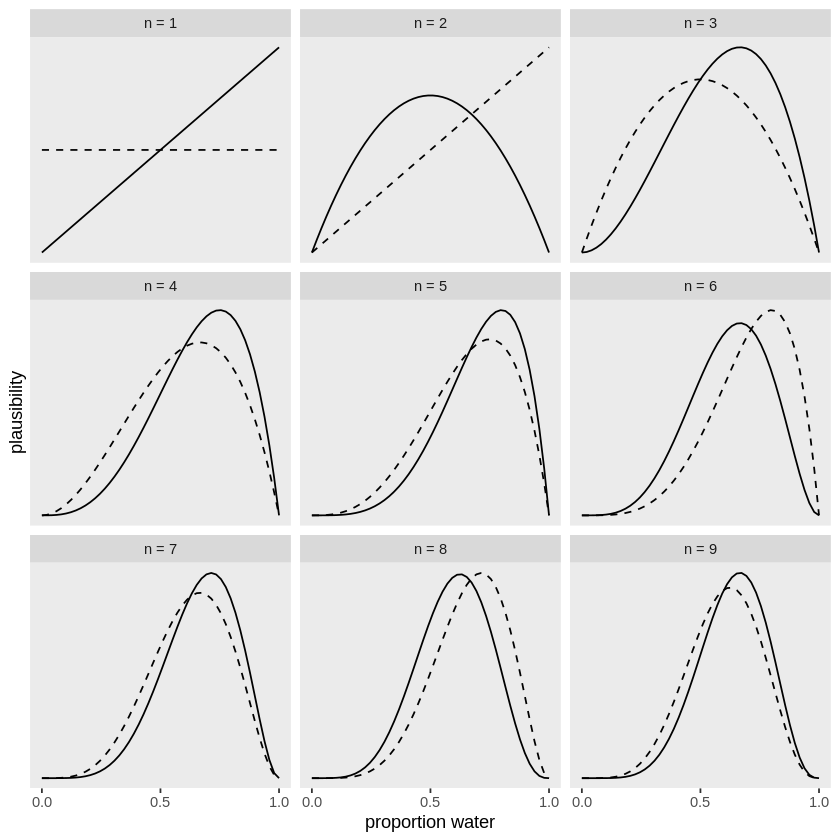

In [38]:
sequence_length <- 50

d %>%
  expand(nesting(n_trials, toss, n_success),
         p_water = seq(from = 0, to = 1, length.out = sequence_length)) %>%
  group_by(p_water) %>%
 # you can learn more about lagging here: https://www.rdocumentation.org/packages/stats/versions/3.5.1/topics/lag or here: https://dplyr.tidyverse.org/reference/lead-lag.html
  mutate(lagged_n_trials  = lag(n_trials, n = 1),
         lagged_n_success = lag(n_success, n = 1)) %>%
  ungroup() %>%
  mutate(prior      = ifelse(n_trials == 1, .5,
                             dbinom(x    = lagged_n_success,
                                    size = lagged_n_trials,
                                    prob = p_water)),
         likelihood = dbinom(x    = n_success,
                             size = n_trials,
                             prob = p_water),
         strip      = str_c("n = ", n_trials)) %>%
  # the next three lines allow us to normalize the prior and the likelihood,
  # putting them both in a probability metric
  group_by(n_trials) %>%
  mutate(prior      = prior / sum(prior),
         likelihood = likelihood / sum(likelihood)) %>%

  # plot!
  ggplot(aes(x = p_water)) +
  geom_line(aes(y = prior),
            linetype = 2) +
  geom_line(aes(y = likelihood)) +
  scale_x_continuous("proportion water", breaks = c(0, .5, 1)) +
  scale_y_continuous("plausibility", breaks = NULL) +
  theme(panel.grid = element_blank()) +
  facet_wrap(~strip, scales = "free_y")


To read this figure, the top left shows how the posterior density goes from flat (the prior) to linear with the introduction of the first datum, a $w$.  The next panel in the figure shows how this line evolves to a parabolic shape with two pieces of data.  By $n=9$, in the lower right, the posterior seems sensible and peaking near $2/3$.

## Motors

All of our inference is going to come from analyzing this posterior. We could find the maximum a posterior (MAP) estimate by looking at the topmost point in the bottom right.  We could ask, for example, the probability that the proportion of water is above 1/2 by looking at the corresponding region of the posterior.

In more complex settings, we cannot picture such a simple density. Instead, we may sample from the posterior and analyze these samples.  

We are going to use a grid sampler to sample from the posterior of the grid example, sampling at a set of discrete points where we have evaluated the posterior and sampling each point proportional to this value.

In the next question, we deal with some more advanced methods.

## Grid Sampling: An Example

In [39]:
(
  d <-
    tibble(p_grid = seq(from = 0, to = 1, length.out = 20),      # define grid
           prior  = 1) %>%                                       # define prior
    mutate(likelihood = dbinom(6, size = 9, prob = p_grid)) %>%  # compute likelihood at each value in grid
    mutate(unstd_posterior = likelihood * prior) %>%             # compute product of likelihood and prior
    mutate(posterior = unstd_posterior / sum(unstd_posterior))   # standardize the posterior, so it sums to 1
)

p_grid,prior,likelihood,unstd_posterior,posterior
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00000000,1,0.000000e+00,0.000000e+00,0.000000e+00
0.05263158,1,1.518149e-06,1.518149e-06,7.989837e-07
0.10526316,1,8.185093e-05,8.185093e-05,4.307717e-05
0.15789474,1,7.772923e-04,7.772923e-04,4.090797e-04
0.21052632,1,3.598575e-03,3.598575e-03,1.893887e-03
0.26315789,1,1.116095e-02,1.116095e-02,5.873873e-03
0.31578947,1,2.668299e-02,2.668299e-02,1.404294e-02
0.36842105,1,5.292110e-02,5.292110e-02,2.785174e-02
0.42105263,1,9.082698e-02,9.082698e-02,4.780115e-02



## Grid Points and Accuracy

Next, we see ho allowing for the evaluation of more grid points, we get a better estimate of the posterior. The problem, of course, is that sampling more points is computationally expensive--a central concern in these models.

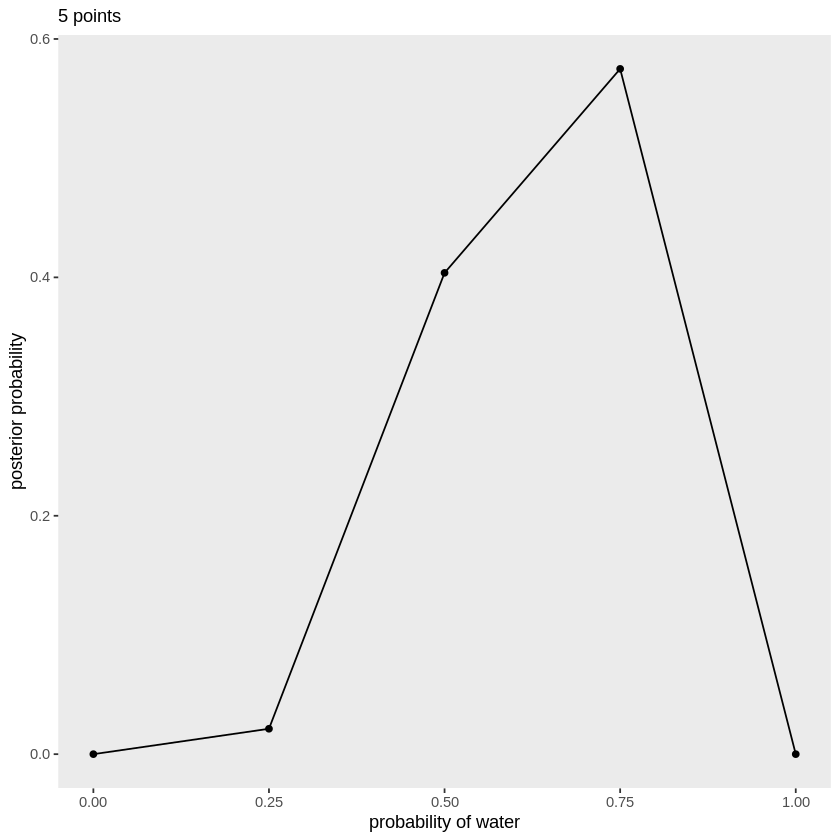

In [40]:
p2 <-
  tibble(p_grid = seq(from = 0, to = 1, length.out = 5),
         prior  = 1) %>%
  mutate(likelihood = dbinom(6, size = 9, prob = p_grid)) %>%
  mutate(unstd_posterior = likelihood * prior) %>%
  mutate(posterior = unstd_posterior / sum(unstd_posterior)) %>%

  ggplot(aes(x = p_grid, y = posterior)) +
  geom_point() +
  geom_line() +
  labs(subtitle = "5 points",
       x = "probability of water",
       y = "posterior probability") +
  theme(panel.grid = element_blank())

p2

## Grid Points and Accuracy


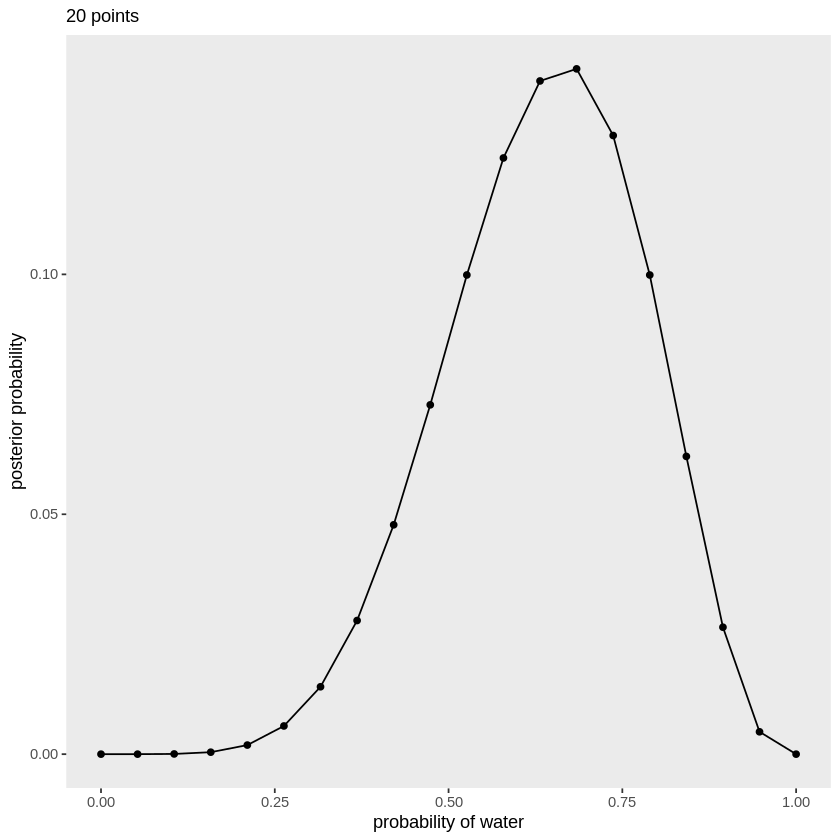

In [41]:
p1 <-
  d %>%
  ggplot(aes(x = p_grid, y = posterior)) +
  geom_point() +
  geom_line() +
  labs(subtitle = "20 points",
       x = "probability of water",
       y = "posterior probability") +
  theme(panel.grid = element_blank())

p1

# Part 2: Sampling Regression Coefficients Using Gibbs, MH, and HMC

The posterior from the previous example is not useful in practice: the model is too simple, and the posterior is one-dimensional. We will never really encounter this in practice in Bayesian statisitics. Next, we turn to a slightly more complex setting, the regression model with known error variance.

## This part's material comes from

"MCMC using Hamiltonian dynamics" by Radford Neal

- <https://arxiv.org/abs/1206.1901>

## Libraries we will need

```{r, echo = TRUE, message=FALSE, warning=FALSE}
library(mixtools)
library(MASS)
```

## Bayesian Regression

Consider a simple model $y_i=X_i^\top \beta+ e_i;\;\; e_i \sim \mathcal N(0,1)$

where $\beta=[2,3]^\top$.

\medskip

We are going to put flat priors on $\beta$ and assume the error variance is known to be $1$, i.e.
\begin{align*}
y_i|X_i, \beta & \sim \mathcal N(X_i^\top \beta,1)\\
\Pr(\beta_j) & \propto 1
\end{align*}

Then, we know
\begin{align*}
\beta|\cdot &\sim \mathcal N\left((X^\top X)^{-1}X^\top y, (X^\top X)^{-1}\right)
\end{align*}

## Methods for Sampling from the Posterior

We are going to consider the following samplers for drawing samples of $\beta$:

-- Joint Gibbs sampler (Gibbs2)

-- Coordinatewise Gibbs (Gibbs1)

--  Metropolis-Hastings (MH)

-- Hamiltonian Monte Carlo (HMC)

## Methods for Assessing the Chains

-- Computational speed

-- Mixing and Convergence

+ Mixing: How quickly does the chain get to its steady state?

+ Convergence: Do multiple chains get to the same place? (Geweke statistic/trace plot)

--  Auto-correlation

+ Does the chain explore the posterior efficiently?

##  Drawing the data
First, let's draw the data:


In [42]:
set.seed(1)
n <- 10
p <- 2
M <- diag(2)
M[M == 0] <- 2 ^ -.5
X <- MASS::mvrnorm(n, c(0, 0), Sigma = M)
X <- apply(X, 2, scale)
y <- X %*% c(2, 3) + rnorm(n)
y <- y - mean(y)


theta.map <- lm(y ~ X)$coef[-1]

theta.map

X1       X2 
1.206412 3.053118

## Functions for MH and HMC

When evaluating the MH and HMC, we will need to evaluate the posterior under the previous and proposed values. Note these are the _negative_ log posterior and log gradient, which is physicists' convention!

In [43]:
logpost <- function(theta) {
  sum((y - X %*% theta) ^ 2) / 2
}

gradpost <- function(theta) {
  -as.vector(t(X) %*% (y - X %*% theta))
}

## Functions

Let's load some functions that we will use.
For now, you can just run this next cell and load the functions. We will revisit them a bit later.

In [44]:
HMC <- function (U, grad_U, epsilon, L, current_q)
{
  q = current_q
  p = rnorm(length(q), 0, 1) # independent standard normal variates
  current_p = p
  # Make a half step for momentum at the beginning
  p = p - epsilon * grad_U(q) / 2
  # Alternate full steps for position and momentum
  for (i in 1:L)
  {
    # Make a full step for the position
    q = q + epsilon * p
    # Make a full step for the momentum, except at end of trajectory
    if (i != L)
      p = p - epsilon * grad_U(q)
  }
  # Make a half step for momentum at the end.
  p = p - epsilon * grad_U(q) / 2
  # Negate momentum at end of trajectory to make the proposal symmetric
  p = -p
  # Evaluate potential and kinetic energies at start and end of trajectory
  current_U = U(current_q)
  current_K = sum(current_p ^ 2) / 2
  proposed_U = U(q)
  proposed_K = sum(p ^ 2) / 2
  # Accept or reject the state at end of trajectory, returning either
  # the position at the end of the trajectory or the initial position
  if (runif(1) < exp(current_U - proposed_U + current_K - proposed_K))
  {
    return (q) # accept
  }
  else
  {
    return (current_q) # reject
  }
}

HMC_NUTS <- function (U, grad_U, epsilon, L, current_q)
{
  q = current_q
  p = rnorm(length(q), 0, 1) # independent standard normal variates
  current_p = p
  # Make a half step for momentum at the beginning
  p = p - epsilon * grad_U(q) / 2
  q.run <- q
  # Alternate full steps for position and momentum
  for (i in 1:L)
  {
    # Make a full step for the position
    q = q + epsilon * p
    q.run <- cbind(q.run, q)
    # Make a full step for the momentum, except at end of trajectory
    if (i != L)
      p = p - epsilon * grad_U(q)
  }
  # Make a half step for momentum at the end.
  p = p - epsilon * grad_U(q) / 2

  q.run
}

MH <- function (U, epsilon, current_q)
{
  q = current_q
  q = current_q + epsilon * rnorm(length(q))
  # Evaluate potential and kinetic energies at start and end of trajectory
  current_U = U(current_q)
  current_K = 0#sum(current_p^2) / 2
  proposed_U = U(q)
  proposed_K = 0#sum(p^2) / 2
  # Accept or reject the state at end of trajectory, returning either
  # the position at the end of the trajectory or the initial position
  if (runif(1) < exp(current_U - proposed_U + current_K - proposed_K))
  {
    return (q) # accept
  }
  else
  {
    return (current_q) # reject
  }
}
